In [49]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from geopy.distance import vincenty
from scipy import spatial
import networkx as nx
import matplotlib.pyplot as plt
from functions import *
import geopandas as gpd
from shapely.geometry import Point
import Parameters as P

In [72]:
data_all = pd.read_csv('../GIS_data/building_all_null.csv')

In [226]:
in_builing_piping_sf = 0.01

In [227]:
data_all['lat_lon'] = data_all.apply(lambda row: (row['y_lat'], row['x_lon']), axis=1)

In [228]:
if len(data_all)>1000:
    k = 1000
else:
    k = len(data_all)

In [229]:
X_lat_lon = list(data_all['lat_lon'])
low = (37.780844, -122.407107)
medium = (37.774191, -122.434905)
high = (37.750458, -122.453315)

query_point = medium
tree = spatial.KDTree(X_lat_lon)
dist, index_select = tree.query(query_point, k=k)


In [230]:
data = pd.DataFrame()
for i in index_select:
    select_row = data_all.iloc[[i]]
    data = data.append(select_row)

In [231]:
X_lat_lon_select = list(data['lat_lon'])
Z = linkage(X_lat_lon_select, 'ward')

In [232]:
data = data.reset_index()

In [233]:
clusters = hierarchical_cluster(X_lat_lon_select, Z)
index_0 = data[(data['y_lat'] - query_point[0])<0.0001].index.tolist()[0]

In [234]:
num_buildings = 1
SUM_pop = data.loc[int(index_0)]['SUM_pop']
building_sqft = data.loc[int(index_0)]['Area_m2']
MIN_ELEV = data.loc[int(index_0)]['ELEV_treat']
inbuilding_floors = data.loc[int(index_0)]['num_floor']
total_dist = building_sqft*in_builing_piping_sf
inbuilding_pumping = pump_energy_building(inbuilding_floors)
inbuilding_flow = SUM_pop*0.2
inbuilding_treatment_energy = find_treatment_energy(SUM_pop, 0)
infrastructure = find_infrastructure_energy(SUM_pop, 0, total_dist)
total_energy = inbuilding_pumping+inbuilding_treatment_energy+infrastructure

In [235]:
cluster_points = []
log_energy = []
cluster_points.append(index_0)
points_checked = []
treatment_log = []
conveyance_log = []
population_log = []
X_lat_lon_to_check = []
totals = {'num_buildings':num_buildings, 'SUM_pop':SUM_pop ,'ELEV_treat':MIN_ELEV, 'total_dist':total_dist, 'inbuilding_pumping':inbuilding_pumping, 'total_energy':total_energy }
G = nx.Graph()
points_checked.append(index_0)
G.add_node(index_0)
for key in clusters.keys():
    if index_0 in clusters[key]:
        add = False
        ids_check = list(set(clusters[key])^set(points_checked))
        for item in ids_check:
            X_lat_lon_to_check.append((X_lat_lon_select[int(item)]))
            
        for start in ids_check:
            points_checked.append(int(start))
            populate_Graph(G, start, data)
            MST_distance = find_MST_distance(G)
            building_floors = data.iloc[int(start)]['num_floor']
            building_sqft = data.iloc[int(start)]['Area_m2']
            building_elevation = data.iloc[int(start)]['ELEV_treat']
            building_population = data.iloc[int(start)]['SUM_pop']
            piping_distance = MST_distance + building_sqft*in_builing_piping_sf
            
            conveyance_energy = find_conveyance_energy(building_elevation, totals['ELEV_treat'], building_floors)
            treatment_energy = find_treatment_energy(building_population, totals['SUM_pop'])
            treatment_embodied = find_treatment_embodied_energy(building_population, totals['SUM_pop'],  ttype = False)
            infrastructure = find_infrastructure_energy(building_population, totals['SUM_pop'], piping_distance)
            total_energy = conveyance_energy + treatment_energy + infrastructure + treatment_embodied
            log_energy.append((start, total_energy))
            
            if total_energy < totals['total_energy']:
                add = True
                cluster_points.append(start)
                totals['num_buildings'] += 1
                totals['SUM_pop'] = totals['SUM_pop'] + data.iloc[int(start)]['SUM_pop']
                totals['ELEV_treat'] = min(totals['ELEV_treat'], data.iloc[int(start)]['ELEV_treat'])
                totals['total_dist'] = totals['total_dist'] + piping_distance
                totals['total_energy'] = total_energy
            
            else:
                G.remove_node(int(start))
                
        if add == False and key !=1:
            break


In [238]:
len(cluster_points)

64

In [239]:
len(points_checked)

87

In [93]:
print (conveyance_energy)
print (treatment_energy)
print (treatment_embodied)
print (infrastructure)

0.6174
25.6763981637
0
0.497223453637


In [179]:
totals

{'ELEV_treat': 54.540999999999997,
 'SUM_pop': 754.9243869999998,
 'inbuilding_pumping': 0.23520000000000002,
 'num_buildings': 46,
 'total_dist': 19678.628109248639,
 'total_energy': 8.3356885110997059}

In [240]:
log1 = []
for item in log_energy:
     log1.append(item[1])

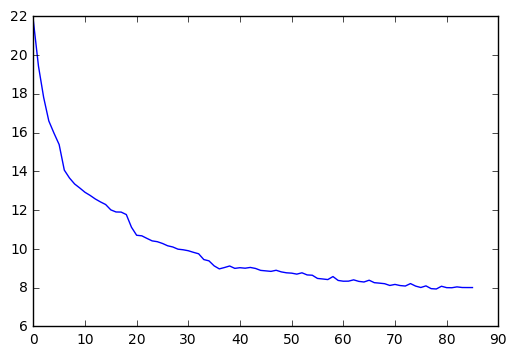

In [241]:
plt.plot(log1)
plt.show()

In [181]:
ids_not = list(set(log1)^set(cluster_points))

In [242]:
output = pd.DataFrame()
for i in cluster_points:
    select_row = data.iloc[[i]]
    output = output.append(select_row)

In [243]:
output.to_csv('med_out_test.csv')

In [184]:
lat_lon_array = list(output['lat_lon'])
hull = ConvexHull(lat_lon_array)
polygon_coords=[]
for simplex in hull.vertices:
    x= lat_lon_array[simplex][1]
    y = lat_lon_array[simplex][0]
    coords = (x,y)
    polygon_coords.append(coords)
polygon_coords_array = [polygon_coords]
polygon = Polygon(polygon_coords_array)

In [185]:
with open('../GIS_data/polygon_%s.geojson' %query_point, 'w') as outfile: 
        json.dump(polygon, outfile)

In [160]:
data = [[17,65.46537000000,8,220.36308300000,(37.77424300000,-122.43476500000)], [17,67.48,8,216,(37.77427400000,-122.43461500000)], 
        [5.8,65,3,197,(37.77419100000,-122.43490500000)]]
column = ['SUM_pop', 'ELEV_treat', 'num_floor','Area_m2', 'lat_lon']
data_all= pd.DataFrame(data=data, columns=column)

In [161]:
data_all

,SUM_pop,ELEV_treat,num_floor,Area_m2,lat_lon
0,17.0,65.46537,8,220.363083,"(37.774243, -122.434765)"
1,17.0,67.48000,8,216.000000,"(37.774274, -122.434615)"
2,5.8,65.00000,3,197.000000,"(37.774191, -122.434905)"


In [175]:
query_point = 0

In [176]:
Z = linkage(list(data_all['lat_lon']), 'ward')

In [177]:
clusters = hierarchical_cluster(list(data_all['lat_lon']), Z)

In [178]:
clusters

{1: [0, 2], 2: [0, 2, 1]}

In [101]:
find_treatment_energy(data_all['SUM_pop'][0],0)

27.77903195538326

In [22]:
pump_energy_building(data_all['Floors'][0])

0.058800000000000005

In [27]:
tot_energy = find_treatment_energy(data_all['SUM_POP'][0]+data_all['SUM_POP'][1],0)+find_conveyance_energy(data_all['ELEV'][1],data_all['ELEV'][0],data_all['Floors'][1])+pump_energy_building(data_all['Floors'][1])

In [ ]:
tot_energy = find_treatment_energy(data_all['SUM_POP'][0]+data_all['SUM_POP'][1],0)+find_conveyance_energy(data_all['ELEV'][1],data_all['ELEV'][0],data_all['Floors'][1])+pump_energy_building(data_all['Floors'][1])